Importing the packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os 
import cv2 
import tensorflow

Dataset link

In [2]:
# Dataset - https://www.kaggle.com/ruizgara/socofing


Dataset path preview

In [3]:
os.listdir('SOCOFing')

['Altered', 'Real', 'SOCOFing']

Importing the Dataset paths

In [4]:
real_path = 'SOCOFing\Real'
altered_easy_path = 'SOCOFing\Altered\Altered-Easy'
altered_medium_path = 'SOCOFing\Altered\Altered-Medium'
altered_hard_path = 'SOCOFing\Altered\Altered-Hard'

Below function will help us in extracting the features from the fingerprints. This function will work by iterating through the labels of the images that we will assign in the function. The function will return an array 0 and 1. The zeros will represent males and ones will be representing the females.

In [5]:
#img_path = SOCOFing\Altered\Altered-Hard\1__M_Left_index_finger_CR.BMP
def extract_label(img_path,train = True):
  filename, _ = os.path.splitext(os.path.basename(img_path))

  subject_id, etc = filename.split('__')
  
  if train:
      gender, lr, finger, _, _ = etc.split('_')
  else:
      gender, lr, finger, _ = etc.split('_')
  
  gender = 0 if gender == 'M' else 1
  lr = 0 if lr == 'Left' else 1

  if finger == 'thumb':
      finger = 0
  elif finger == 'index':
      finger = 1
  elif finger == 'middle':
      finger = 2
  elif finger == 'ring':
      finger = 3
  elif finger == 'little':
      finger = 4
  return np.array([gender],dtype=np.uint16)

Now our next step is to load the image path to the function we created to iterate all over the images to find labels

In [6]:
img_size = 96

def loading_data(path,train):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            label = extract_label(os.path.join(path, img),train)
            data.append([label[0], img_resize ])
        except Exception as e:
            pass
    data
    return data

Loading the Datsets

In [7]:
Easy_data = loading_data(altered_easy_path, train = True)
Medium_data = loading_data(altered_medium_path, train = True)
Hard_data = loading_data(altered_hard_path, train = True)
test = loading_data(real_path, train = False)

data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)

del Easy_data, Medium_data, Hard_data

loading data from:  SOCOFing\Altered\Altered-Easy
loading data from:  SOCOFing\Altered\Altered-Medium
loading data from:  SOCOFing\Altered\Altered-Hard
loading data from:  SOCOFing\Real


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Now let’s randomize the data and test the arrays to see what our data looks like:

In [8]:
import random as rd
rd.shuffle(test)
rd.shuffle(data)
data[0]

array([0,
       array([[160, 158, 158, ...,   0,   0,   0],
       [160, 105, 121, ...,   0,   0,   0],
       [160, 105, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)], dtype=object)

The output above is showing how our images are present in the data. The first array is representing the label value of 0 and then we have an array of pixel values.

Now ,I will split the data into label and image array and perform resizing and normalizing


In [10]:
from tensorflow.keras.utils import to_categorical

In [11]:
img, labels = [], []
for label, feature in data:
    labels.append(label)
    img.append(feature)
train_data = np.array(img).reshape(-1, img_size, img_size, 1)
train_data = train_data / 255.0
train_labels  = to_categorical(labels, num_classes = 2)

In [12]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten 
from tensorflow.keras import optimizers

#from 

In [13]:
model = Sequential([
                    Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = [96, 96, 1]),
                    MaxPooling2D(2),
                    Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
                    MaxPooling2D(2),
                    Flatten(),
                    Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(2, activation = 'softmax'),
                    ])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

Now, I will compile the model using Adam optimizers, with a learning rate of 10%, and to prevent our CNN model from overfitting, I will be using the early_stopping_call method:



In [15]:
model.compile(optimizer = optimizers.Adam(1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping_cb = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [16]:
history = model.fit(train_data, train_labels, batch_size = 128, epochs = 10, 
          validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 1)

Epoch 1/10
308/308 [==============================] - 484s 2s/step - loss: 0.5713 - accuracy: 0.7937 - val_loss: 0.4093 - val_accuracy: 0.8255
Epoch 2/10
308/308 [==============================] - 373s 1s/step - loss: 0.2483 - accuracy: 0.9005 - val_loss: 0.2392 - val_accuracy: 0.9020
Epoch 3/10
308/308 [==============================] - 375s 1s/step - loss: 0.1160 - accuracy: 0.9596 - val_loss: 0.1518 - val_accuracy: 0.9451
Epoch 4/10
308/308 [==============================] - 377s 1s/step - loss: 0.0627 - accuracy: 0.9801 - val_loss: 0.1351 - val_accuracy: 0.9501
Epoch 5/10
308/308 [==============================] - 407s 1s/step - loss: 0.0385 - accuracy: 0.9889 - val_loss: 0.1009 - val_accuracy: 0.9653
Epoch 6/10
308/308 [==============================] - 428s 1s/step - loss: 0.0231 - accuracy: 0.9942 - val_loss: 0.1339 - val_accuracy: 0.9568
Epoch 7/10
308/308 [==============================] - 457s 1s/step - loss: 0.0196 - accuracy: 0.9949 - val_loss: 0.1051 - val_accuracy: 0.9679

Now, we have successfully trained our CNN for Gender Classification Model with a training accuracy of 99 per cent and Validation accuracy of 98 per cent. Now, let’s have a look at the performance of our Gender Classification Model:

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

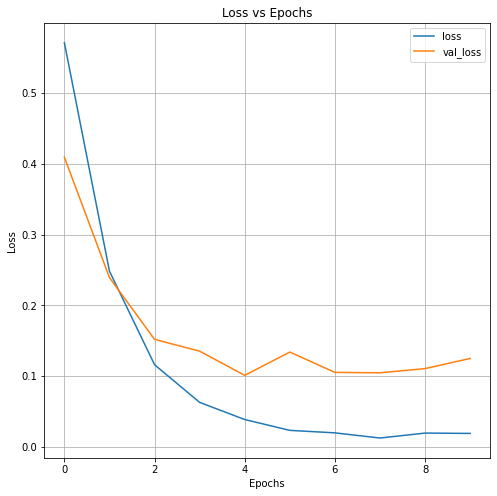

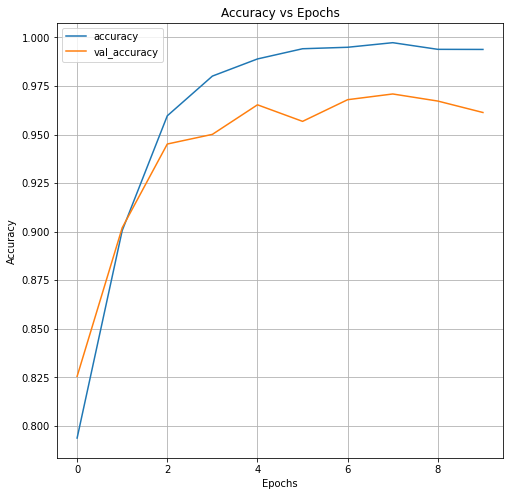

In [43]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(['loss','val_loss'])
plt.grid(True)
#plt.gca().set_ylim(0,1)
plt.show()


plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['accuracy','val_accuracy'])
plt.grid(True)
#plt.gca().set_ylim(0,1)
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)




Testing Gender Classification Model

As we split the training images into image labels and image arrays while training our model, we need to repeat the same process on the test images:

In [45]:
test_images, test_labels = [], []

for label, feature in test:
    test_images.append(feature)
    test_labels.append(label)
    
test_images = np.array(test_images).reshape(-1, img_size, img_size, 1)
test_images = test_images / 255.0
del test
test_labels  = to_categorical(test_labels, num_classes = 2)

Now, let’s evaluate the performance of our CNN model on the test set:

In [46]:
model.evaluate(test_images, test_labels)

188/188 [==============================] - 25s 135ms/step - loss: 0.0678 - accuracy: 0.9837


[0.06778135895729065, 0.9836666584014893]

Saving the Model and loading the model

In [ ]:
model.save('finger_print.h5')

from tensorflow.keras.models import load_model
classifier = load_model('finger_print.h5')

In [70]:
test_pred = classifier.predict(test_images)

In [50]:
classes = ['Male','Female']

array([1.0000e+00, 2.7269e-09], dtype=float32)

In [64]:
test_predd = np.argmax(test_pred,axis = 1)

In [76]:
test_label = np.argmax(test_labels,axis = 1)

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [86]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(test_label,test_predd)
print(cm)
accuracy_score(test_label,test_predd)

[[4721   49]
 [  49 1181]]


0.9836666666666667

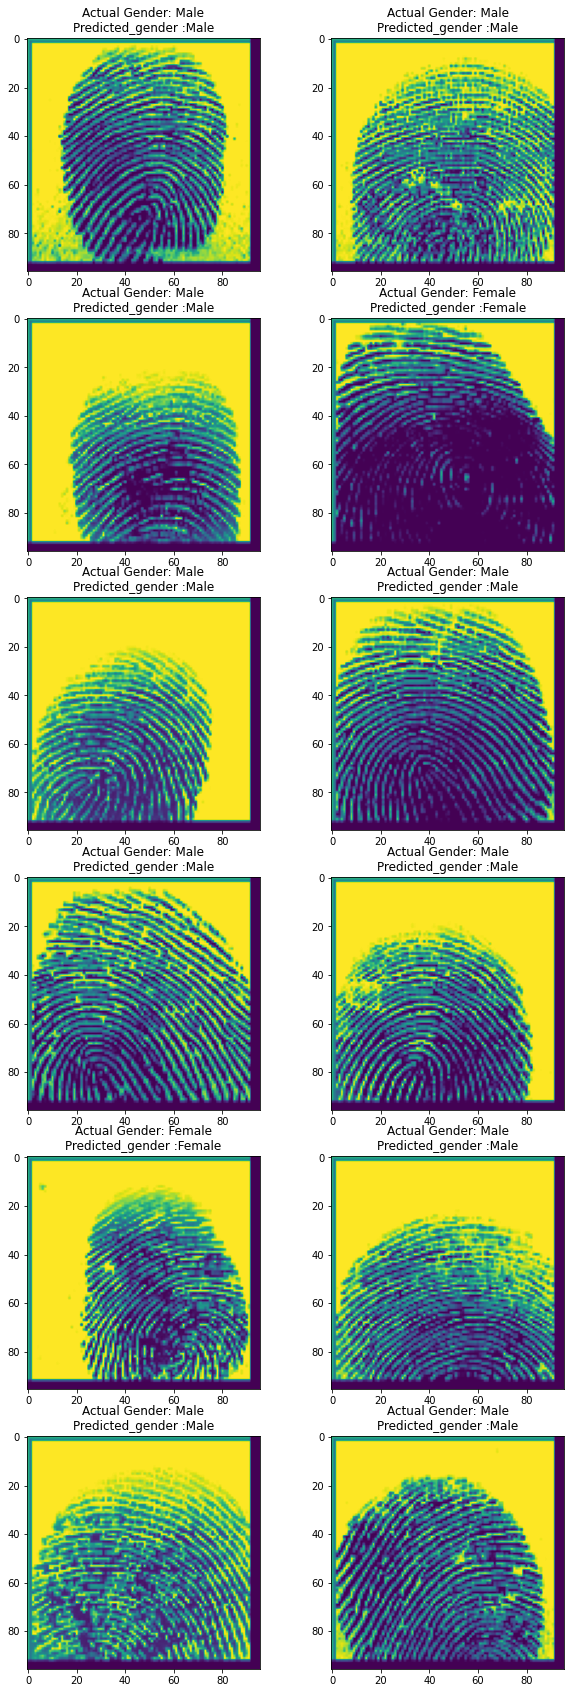

In [95]:
import random 
fig , ax = plt.subplots(6,2)
fig.set_size_inches(10,30)
for i in range(6):
    for j in range(2):
        l = random.randint(0,1000)
        ax[i,j].imshow(test_images[l])
        ax[i,j].set_title('Actual Gender: '+classes[test_label[l]] +'\n' + 'Predicted_gender :' + classes[test_predd[l]])
